In [1]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
inline_rc = dict(plt.rcParams)
import numpy as np

from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import average
from scipy.cluster.hierarchy import dendrogram


import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math

import scipy.spatial.distance
from scipy.spatial.distance import *

import sklearn
import sklearn.preprocessing

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

In [3]:
#
# load selected data from Eisen 1998
# 

e98 = pd.read_csv("eisen_1998_sel.txt", sep="\t")

#
# get a list of data columns
#

e98_datacols = e98.columns.values[2:]

#
# get data matrix
#

e98_data = e98[e98_datacols].fillna(0).values

#
# make copy of data where all genes have unit norm for some applications
#

e98_datan = sklearn.preprocessing.normalize(e98_data)

#
# get a list of genes
#

e98_genes = e98['ORF']



In [5]:
e98.columns

Index(['ORF', 'NAME', 'alpha 0', 'alpha 7', 'alpha 14', 'alpha 21', 'alpha 28',
       'alpha 35', 'alpha 42', 'alpha 49', 'alpha 56', 'alpha 63', 'alpha 70',
       'alpha 77', 'alpha 84', 'alpha 91', 'alpha 98', 'alpha 105',
       'alpha 112', 'alpha 119', 'Elu 0', 'Elu 30', 'Elu 60', 'Elu 90',
       'Elu 120', 'Elu 150', 'Elu 180', 'Elu 210', 'Elu 240', 'Elu 270',
       'Elu 300', 'Elu 330', 'Elu 360', 'Elu 390', 'cdc15 10', 'cdc15 30',
       'cdc15 50', 'cdc15 70', 'cdc15 90', 'cdc15 110', 'cdc15 130',
       'cdc15 150', 'cdc15 170', 'cdc15 190', 'cdc15 210', 'cdc15 230',
       'cdc15 250', 'cdc15 270', 'cdc15 290', 'spo 0', 'spo 2', 'spo 5',
       'spo 7', 'spo 9', 'spo 11', 'spo5 2', 'spo5 7', 'spo5 11', 'spo- early',
       'spo- mid', 'heat 0', 'heat 10', 'heat 20', 'heat 40', 'heat 80',
       'heat 160', 'dtt 15', 'dtt 30', 'dtt 60', 'dtt 120', 'cold 0',
       'cold 20', 'cold 40', 'cold 160', 'diau a', 'diau b', 'diau c',
       'diau d', 'diau e', 'diau f', 'diau g'

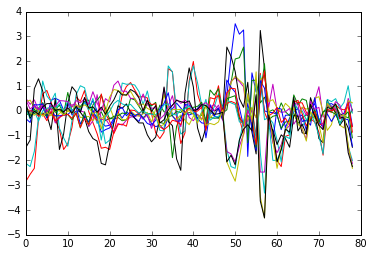

In [6]:
rows = [0,1,14,15,23,24,26,27,29,30,40,41,42,43]

for r in rows:
    plt.plot(e98_data[r])

In [8]:
e98.iloc[rows,:][e98_datacols]

,alpha 0,alpha 7,alpha 14,alpha 21,alpha 28,alpha 35,alpha 42,alpha 49,alpha 56,alpha 63,...,cold 20,cold 40,cold 160,diau a,diau b,diau c,diau d,diau e,diau f,diau g
0,0.14,-0.12,0.25,-0.12,0.16,-0.30,0.42,0.51,0.42,0.03,...,0.29,-0.34,-0.69,0.26,0.29,0.18,-0.18,-0.10,0.39,-0.62
1,-0.14,-0.14,-0.12,0.11,0.33,NaN,-0.12,0.04,0.23,-0.12,...,-0.23,-0.43,-0.09,0.18,0.12,0.20,-0.12,-0.20,-0.29,0.06
14,-2.84,-2.56,-2.32,-0.32,0.68,0.82,0.37,-0.36,-0.74,-1.56,...,-0.45,-0.86,-1.79,NaN,-0.06,0.24,0.08,0.04,0.14,-0.64
15,-2.12,-2.25,-1.64,-0.30,1.20,0.60,0.38,0.71,-0.71,-1.09,...,-0.14,-0.30,-0.69,0.46,0.37,0.49,0.10,0.34,1.01,-0.09
23,0.50,0.26,0.44,0.04,0.25,-0.20,0.12,-0.49,-0.29,-0.10,...,0.39,0.97,-0.25,-0.06,0.06,0.37,0.23,-0.32,0.50,NaN
24,0.37,0.43,0.12,0.01,-0.17,0.11,-0.15,-0.22,-0.12,0.08,...,0.50,0.57,-0.04,-0.79,-0.56,0.12,-0.58,-0.69,0.41,0.32
26,-1.47,-1.18,0.89,1.29,0.80,-0.17,-0.76,0.48,-1.56,-0.94,...,-0.03,-1.12,-1.29,0.41,0.14,-0.06,-0.58,-0.34,-0.69,-1.47
27,-0.32,-0.47,0.24,0.24,0.28,-0.25,-0.06,-0.20,-0.20,-0.18,...,0.53,-0.47,-0.64,-0.12,-0.43,-0.15,-0.32,-0.32,-0.36,-1.43
29,-0.01,-0.20,0.07,-0.17,-0.09,-0.22,0.21,-0.06,0.03,-0.10,...,0.07,-0.47,-0.03,0.01,-0.04,-0.14,-0.51,-0.20,-0.04,-1.09
30,0.06,0.01,-0.04,-0.22,-0.12,-0.40,-0.01,-0.42,-0.25,-0.18,...,-0.03,-0.58,-0.51,0.06,0.01,0.06,-0.32,-0.22,0.33,-0.86


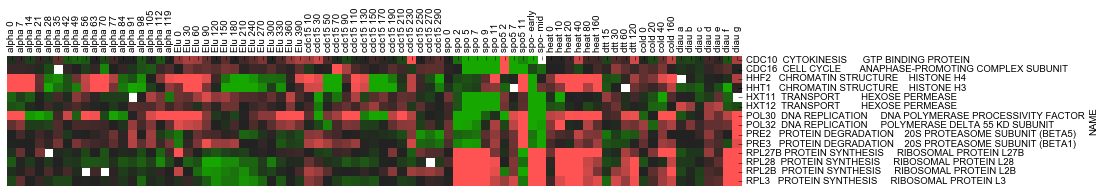

In [7]:
rows = [0,1,14,15,23,24,26,27,29,30,40,41,42,43]

e98_plot = e98.set_index('NAME').iloc[rows,:][e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)

Time to study some distance function

https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

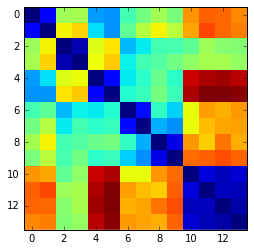

In [12]:
# distance functions don't like missing data 

plt.rcParams.update(inline_rc)

e98_sub = e98.set_index('NAME').iloc[rows,:][e98_datacols].fillna(0).values

e98_sub_pw = pdist(e98_sub, metric = 'cosine')
e98_sub_sf = squareform(e98_sub_pw) 
plt.imshow(e98_sub_sf, interpolation='none')

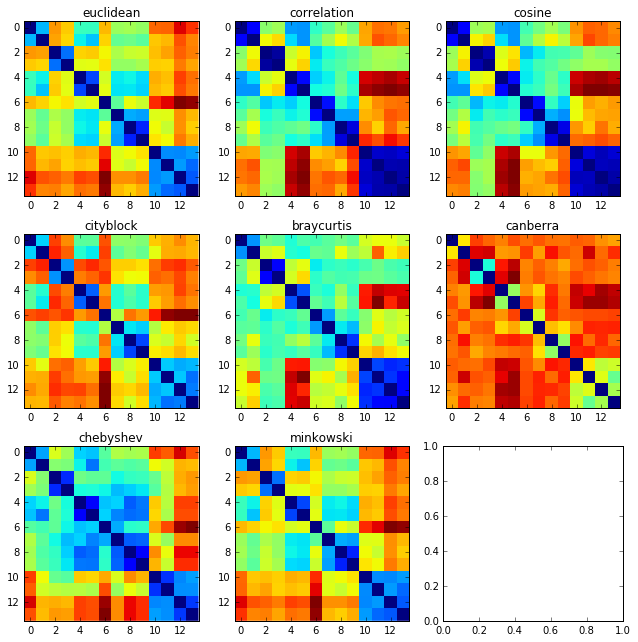

In [14]:
plt.rcParams.update(inline_rc)

dist_funcs = ['euclidean','correlation','cosine','cityblock','braycurtis','canberra','chebyshev','minkowski']

fig, axes = plt.subplots(3,3,figsize=(9,9))

for i,d in enumerate(dist_funcs):

    r = int(i/3)
    c = i % 3
    sfd = squareform(pdist(e98_sub, metric = d))
    axes[r][c].imshow(sfd, interpolation='none')
    axes[r][c].set_title(d)

fig.tight_layout()

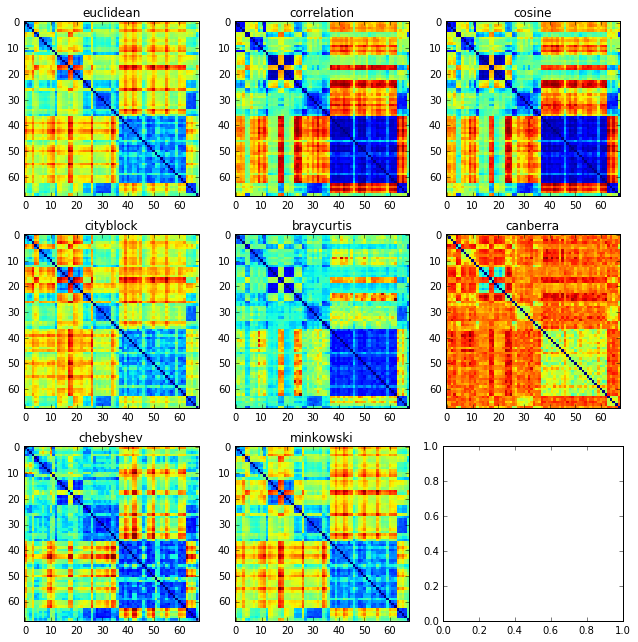

In [8]:
plt.rcParams.update(inline_rc)

dist_funcs = ['euclidean','correlation','cosine','cityblock','braycurtis','canberra','chebyshev','minkowski']

fig, axes = plt.subplots(3,3,figsize=(9,9))

for i,d in enumerate(dist_funcs):

    r = int(i/3)
    c = i % 3
    sfd = squareform(pdist(e98_data, metric = d))
    axes[r][c].imshow(sfd, interpolation='none')
    axes[r][c].set_title(d)

fig.tight_layout()

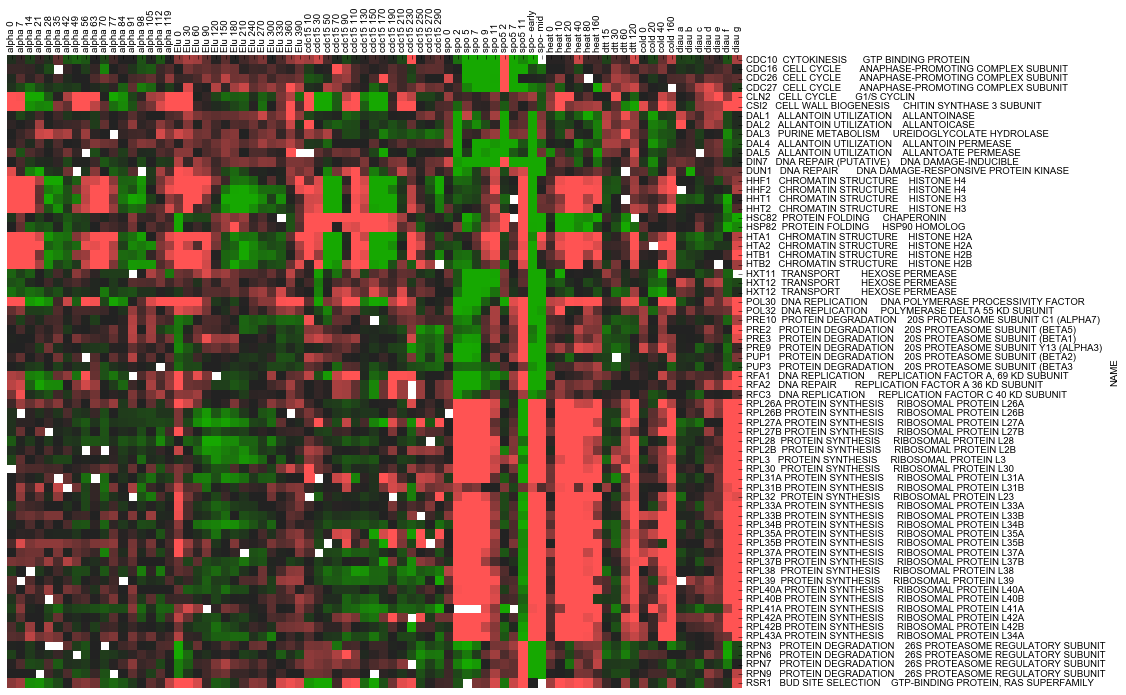

In [17]:
e98_plot = e98.set_index('NAME')[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)



In [18]:
#
# load selected data from Eisen 1998
# 

e98 = e98.sample(frac=1)

#
# get data matrix
#

e98_data = e98[e98_datacols].fillna(0).values

#
# make copy of data where all genes have unit norm for some applications
#

e98_datan = sklearn.preprocessing.normalize(e98_data)

#
# get a list of genes
#

e98_genes = e98['ORF']

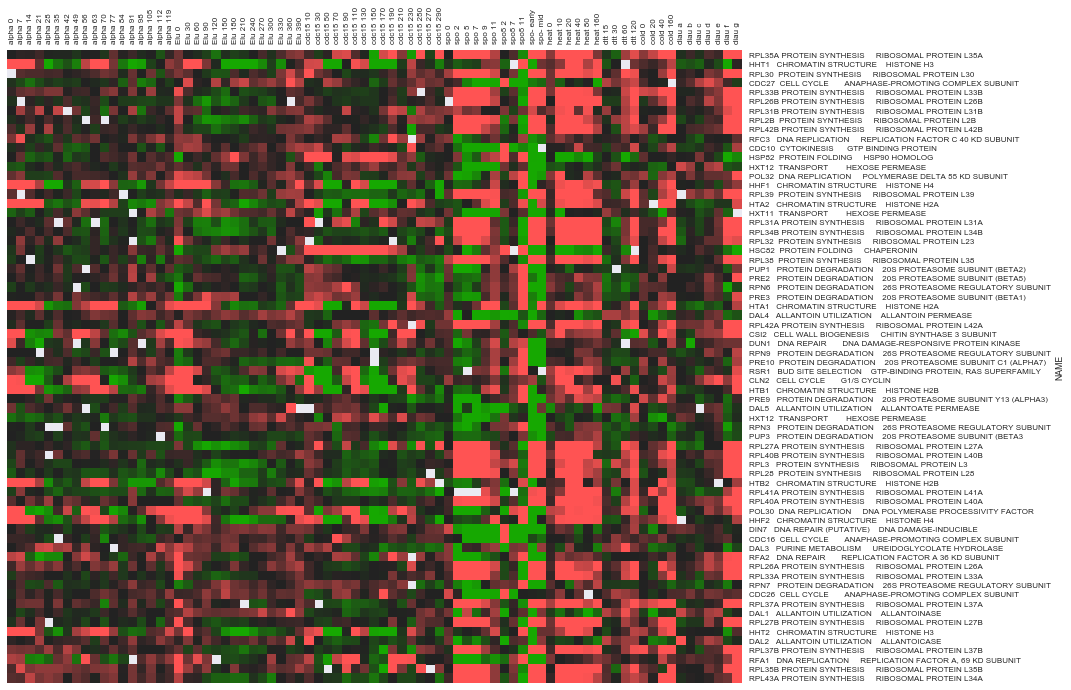

In [19]:
e98_plot = e98.set_index('NAME')[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)



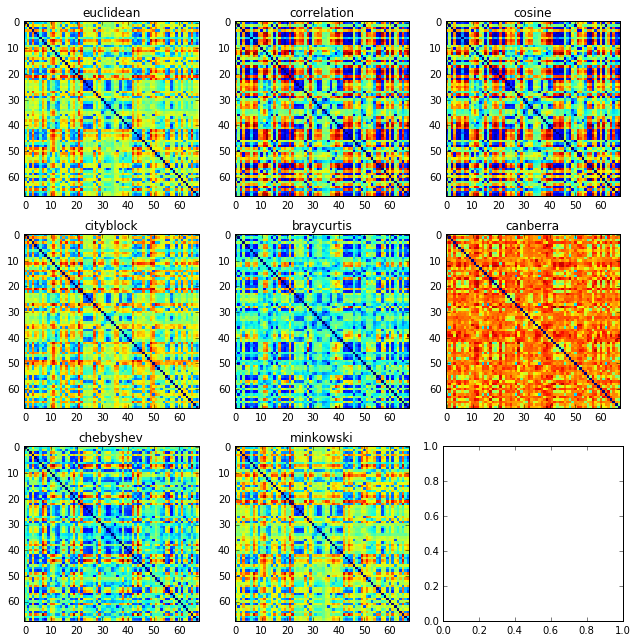

In [20]:
plt.rcParams.update(inline_rc)

dist_funcs = ['euclidean','correlation','cosine','cityblock','braycurtis','canberra','chebyshev','minkowski']

fig, axes = plt.subplots(3,3,figsize=(9,9))

for i,d in enumerate(dist_funcs):

    r = int(i/3)
    c = i % 3
    sfd = squareform(pdist(e98_data, metric = d))
    axes[r][c].imshow(sfd, interpolation='none')
    axes[r][c].set_title(d)

fig.tight_layout()

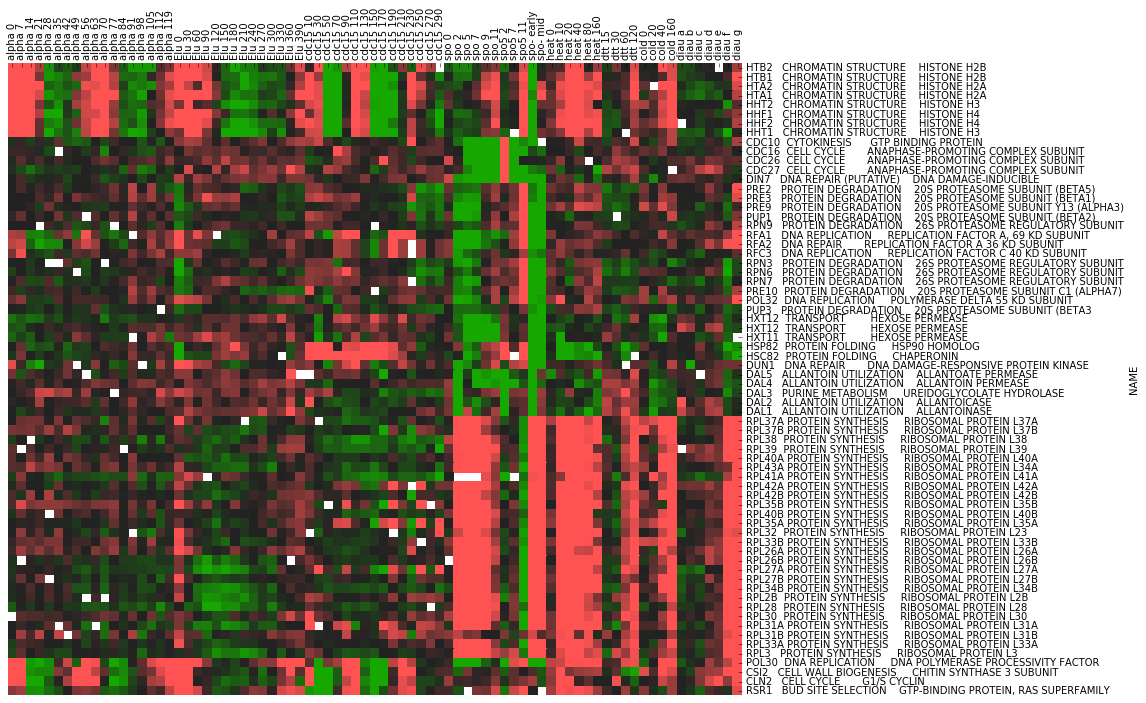

In [9]:
nc = 5

X = e98_data

cl = KMeans(n_clusters = nc, init = 'k-means++')
cl.fit(X)
e98['km'] = cl.fit_predict(X)

e98_plot = e98.set_index('NAME').sort_values('km')[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)

plt.rcParams.update(inline_rc)

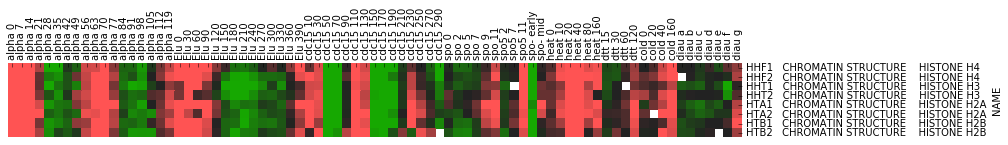

In [10]:
#
# plot groups
#

e98_plot = e98[e98['km'] == 0].set_index('NAME')[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)

plt.rcParams.update(inline_rc)



In [11]:
X = e98_data

ac = AgglomerativeClustering(n_clusters = 10, affinity='cosine', linkage='average')
ac.fit(X)
cl = ac.fit_predict(X)

In [12]:
ac.children_

array([[ 14,  21],
       [ 42,  48],
       [ 38,  50],
       [ 19,  68],
       [ 49,  53],
       [ 69,  70],
       [ 40,  60],
       [ 57,  61],
       [ 13,  71],
       [ 15,  16],
       [ 37,  44],
       [ 41,  43],
       [ 55,  56],
       [ 62,  72],
       [ 73,  74],
       [ 20,  76],
       [  4,   5],
       [ 77,  83],
       [ 75,  81],
       [ 39,  82],
       [ 58,  80],
       [ 79,  87],
       [ 54,  86],
       [ 17,  18],
       [ 22,  85],
       [ 63,  65],
       [ 88,  90],
       [ 45,  89],
       [ 78,  94],
       [  0,  11],
       [ 95,  96],
       [ 34,  35],
       [ 29,  30],
       [ 66,  93],
       [  1,   3],
       [ 26,  99],
       [ 47,  98],
       [  9,  10],
       [ 97, 102],
       [ 32, 100],
       [  6,   7],
       [ 23,  24],
       [ 31,  64],
       [ 27, 103],
       [101, 110],
       [ 51, 104],
       [ 12, 111],
       [ 52, 113],
       [ 25, 109],
       [  2, 106],
       [107, 112],
       [  8, 108],
       [ 67,

In [29]:
def parse_tree(children,node):
    if len(children[node]) == 1:
        return [node]
    else:
        return parse_tree(children,children[node][0]) + parse_tree(children,children[node][1]) 

In [30]:
leaves = ac.n_leaves_
children = []
for i in range(0,leaves):
    children.append([i])
for i in ac.children_:
    children.append([i[0],i[1]])
    
order = parse_tree(children,len(children)-1)

inorder = np.zeros(len(order),dtype=int)
for i,o in enumerate(order):
    inorder[o] = i   
e98['order'] = inorder
    

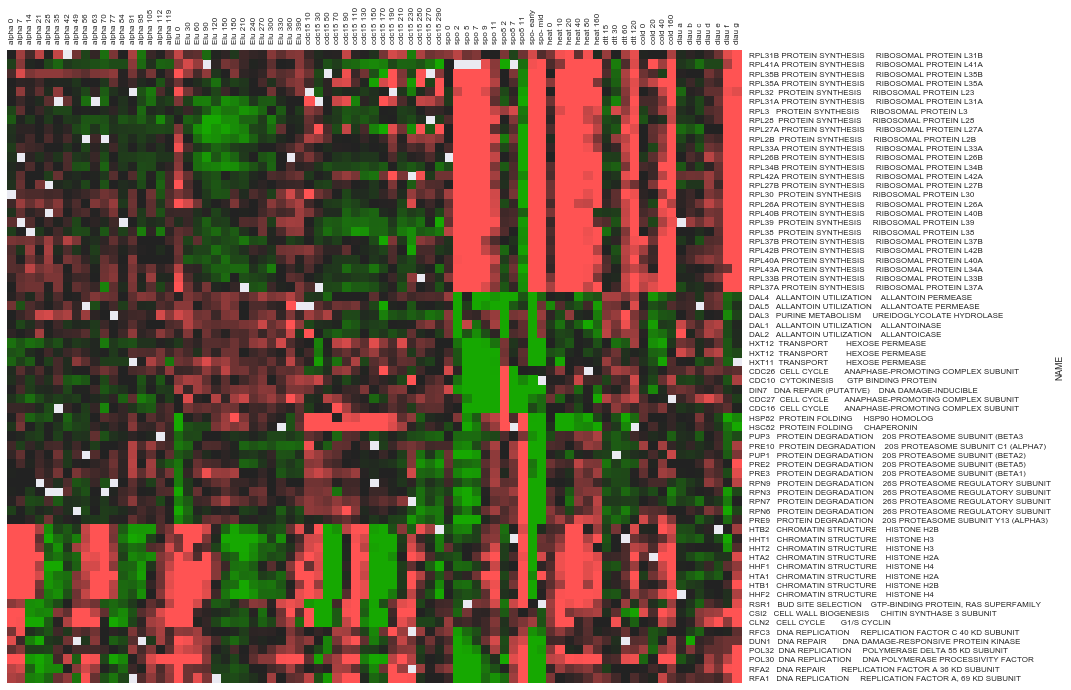

In [36]:
e98_plot = e98.set_index('NAME').sort_values('order')[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

fig, ax = plt.subplots(1,1,figsize=(xs,ys))
cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)

sns.set(font_scale=0.8)

hm = sns.heatmap(e98_plot, cmap=cmap, vmin = -1.0, vmax = 1.0, center=0,xticklabels = True, 
                 yticklabels = True, cbar = False)

# x axis on top

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
xticklabels = ax.get_xticklabels()
h = ax.set_xticklabels(xticklabels, rotation = 90)

# y axis on right

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
yticklabels = ax.get_yticklabels()
h = ax.set_yticklabels(yticklabels, rotation = 0)

plt.rcParams.update(inline_rc)


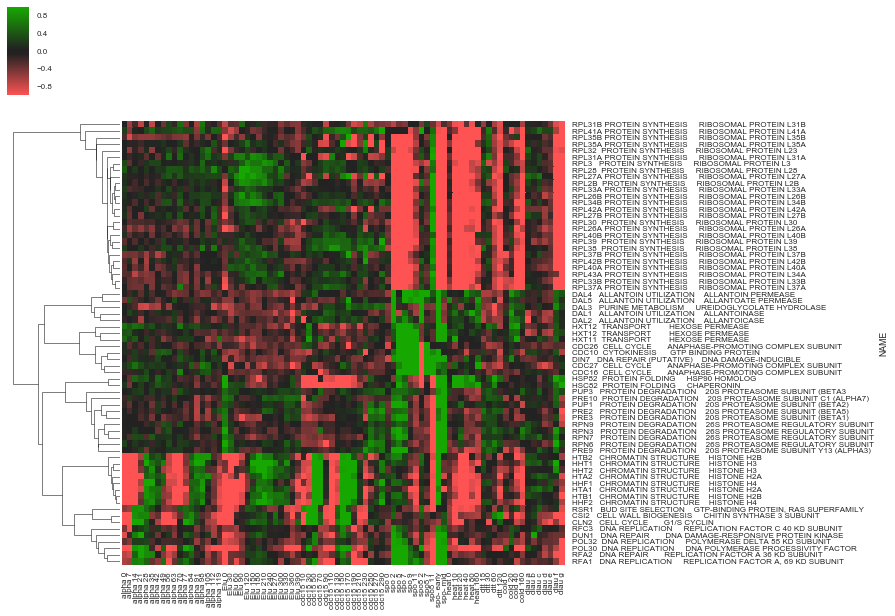

In [65]:

e98_plot = e98.set_index('NAME').fillna(0)[e98_datacols]

cpi = 6
xs = len(e98_datacols)/cpi
ys = len(e98_plot)/cpi

plt.figsize=(xs,ys)

cmap = sns.diverging_palette(12.2, 127, s=99.9, l=60.0,n=10, center="dark", as_cmap=True)
sns.set(font_scale=0.8)
cm = sns.clustermap(e98_plot, method='average',metric='cosine',cmap=cmap,vmin = -1.0, vmax = 1.0, xticklabels = True, 
                 yticklabels = True, row_cluster = True, col_cluster = False)

In [66]:
#
# load selected data from Eisen 1998
# 

e98 = pd.read_csv("eisen_1998.txt", sep="\t")

#
# get a list of data columns
#

e98_datacols = e98.columns.values[2:]

#
# get data matrix
#

e98_data = e98[e98_datacols].fillna(0).values

#
# make copy of data where all genes have unit norm for some applications
#

e98_datan = sklearn.preprocessing.normalize(e98_data)

#
# get a list of genes
#

e98_genes = e98['ORF']
